In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
from profiler import *
from utils import *
from datasets import *
from models import *
from transforms import *
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.models import densenet121
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')

Available workers: 16


# Raspberry-Pi Data

In [ ]:
model = densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs,2)
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/model_stft_best.pth.tar', model, optimizer)
model = model.to('cuda', dtype=torch.float)

In [8]:
dspath = "/home/kalfasyan/data/wingbeats/wingbeats_20211129/wingbeats_correct_dates/Melanogaster_202111_RPi"
wbpf = WingbeatDatasetProfiler(dsname=dspath, custom_label=[0], rpiformat=True)

maxpeaks = 15
minpeaks = 1
maxscore = 12
minscore = 3.5
selection = f"peaks>{minpeaks} & peaks<{maxpeaks} & score>{minscore} & score<={maxscore}"
wbpf.df = wbpf.df.query(selection)

Found 127 in dataset: /home/kalfasyan/data/wingbeats/wingbeats_20211129/wingbeats_correct_dates/Melanogaster_202111_RPi, and 1 label(s): ['wingbeats_correct_dates']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.


In [9]:
evaluate_data(wbpf.df, model, transforms_list=[Bandpass(lowcut=140, highcut=1500), TransformWingbeat(setting='stftcropresize')])

Testing..	:   0%|          | 0/3 [02:23<?, ?it/s]


KeyboardInterrupt: 

# SD card data

In [ ]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [ ]:
import sys
sys.path.insert(0,"..")
from profiler import *
from utils import *
from datasets import *
from models import *
from transforms import *
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')

transforms_list_test = [Bandpass(lowcut=140, highcut=1500), TransformWingbeat(setting='stftcropresize')]
BASE_DATACREATEDDIR

In [ ]:
model = densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs,2)
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/model_stft_best.pth.tar', model, optimizer)
model = model.to('cuda', dtype=torch.float)

In [19]:
dspath = "/home/kalfasyan/data/wingbeats/wingbeats_20211129/wingbeats_correct_dates/Melanogaster_202111_SD"
wbpf = WingbeatDatasetProfiler(dsname=dspath, custom_label=[0], rpiformat=False)

maxpeaks = 15
minpeaks = 1
maxscore = 12
minscore = 3.5
selection = f"peaks>{minpeaks} & peaks<{maxpeaks} & score>{minscore} & score<={maxscore}"
wbpf.df = wbpf.df.query(selection)

Found 11136 in dataset: /home/kalfasyan/data/wingbeats/wingbeats_20211129/wingbeats_correct_dates/Melanogaster_202111_SD, and 1 label(s): ['wingbeats_correct_dates']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.


### Testing with new SD card data

In [20]:
evaluate_data(wbpf.df, model, transforms_list=transforms_list_test)

Testing..	: 100%|██████████| 185/185 [00:07<00:00, 24.39it/s]
/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Accuracy: 87.01
Balanced accuracy: 87.01
Confusion matrix: 
[[0.87005745 0.12994255]
 [0.         0.        ]]
0    5149
1     769
dtype: int64


### Testing with original controlled test set

In [22]:
test_df = pd.read_parquet('../data_created/suzmel_test.parquet')
test_dataset = DataFrameset(pd.concat([test_df.iloc[:,0], test_df.iloc[:,1]], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
_ = test_model(model,test_dataloader, test_dataset)

Testing..	: 100%|██████████| 803/803 [00:08<00:00, 89.93it/s] 

Accuracy: 86.80
Balanced accuracy: 86.63
Confusion matrix: 
[[0.83582336 0.16417664]
 [0.10331858 0.89668142]]


### Testing with remote-uncontrolled test set

In [21]:
extra_df = pd.read_csv('../data_created/suzmel_extra.csv')
X_extra, y_extra = extra_df.iloc[:,0], extra_df.iloc[:,1]

extra_dataset = DataFrameset(pd.concat([X_extra, y_extra], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
_ = test_model(model,extra_dataloader, extra_dataset)

Testing..	: 100%|██████████| 797/797 [00:08<00:00, 93.67it/s] 

Accuracy: 81.44
Balanced accuracy: 85.12
Confusion matrix: 
[[0.89251997 0.10748003]
 [0.19003193 0.80996807]]


# UMAP

In [24]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [25]:
import sys
sys.path.insert(0,"..")
from profiler import *
from utils import *
from datasets import *
from models import *
from transforms import *
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
torchaudio.set_audio_backend('soundfile')

transforms_list_test = [Bandpass(lowcut=140, highcut=1500), TransformWingbeat(setting='psdl2')]
BASE_DATACREATEDDIR

Path('/home/kalfasyan/projects/wbai/data_created')

In [26]:
model = DrosophilaNetRAW(outputs=2, dropout_p=.2)
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
model, optimizer = load_checkpoint(f'{BASE_DATACREATEDDIR}/model_psd.pth.tar', model, optimizer)
model = model.to('cuda', dtype=torch.float)

In [27]:
dspath = "/home/kalfasyan/data/wingbeats/wingbeats_20211129/wingbeats_correct_dates/Melanogaster_202111_SD"
wbpf = WingbeatDatasetProfiler(dsname=dspath, custom_label=[0], rpiformat=False)

maxpeaks = 15
minpeaks = 1
maxscore = 12
minscore = 3.5
selection = f"peaks>{minpeaks} & peaks<{maxpeaks} & score>{minscore} & score<={maxscore}"
wbpf.df = wbpf.df.query(selection)

Found 11136 in dataset: /home/kalfasyan/data/wingbeats/wingbeats_20211129/wingbeats_correct_dates/Melanogaster_202111_SD, and 1 label(s): ['wingbeats_correct_dates']
Label(s) changed to [0]


Creating a pandas Dataframe with file-paths, clean-scores, duration, sums of abs values, indice and labels..
Finished.


In [29]:
test_df = pd.read_parquet('../data_created/suzmel_test.parquet')
test_dataset = DataFrameset(pd.concat([test_df.iloc[:,0], test_df.iloc[:,1]], axis=1), transform=transforms.Compose(transforms_list_test))
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [68]:
out = get_all_preds(model, test_dataloader)
X_test = out[0].detach().cpu().numpy()
y_test = out[1].detach().cpu().numpy()

100%|██████████| 803/803 [00:08<00:00, 90.67it/s] 


In [69]:
extra_df = pd.read_csv('../data_created/suzmel_extra.csv')
extra_dataset = DataFrameset(pd.concat([extra_df.iloc[:,0], extra_df.iloc[:,1]], axis=1), transform=transforms.Compose(transforms_list_test))
extra_dataloader = DataLoader(extra_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
out_xtra = get_all_preds(model, test_dataloader)
X_extra = out_xtra[0].detach().cpu().numpy()
y_extra = out_xtra[1].detach().cpu().numpy()

100%|██████████| 803/803 [00:08<00:00, 92.37it/s] 


In [94]:
X_test_and_xtra = np.vstack((X_test,X_extra))
y_test_and_xtra = np.hstack((y_test, y_extra))

In [96]:
y_test_and_xtra.shape

(51350,)

In [86]:
import umap
reducer = umap.UMAP()


In [88]:
embedding = reducer.fit_transform(X_test_and_xtra)

In [89]:
embedding.shape

(51350, 2)

In [93]:
import seaborn as sns
y_test_and_xtra.shape

(2, 25675)

<AxesSubplot:>

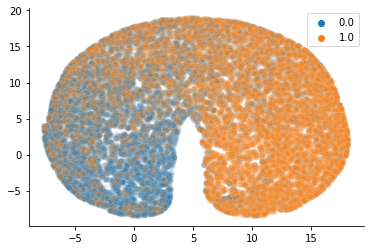

In [103]:
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=y_test_and_xtra, alpha=0.08)